In [1]:
from scipy.signal import butter, filtfilt, find_peaks, freqz, sosfilt
import scipy as sp
import matplotlib.pyplot as plt 
%matplotlib widget
import numpy as np 
import pandas as pd 
import gc
import cupy as cp
import multiprocessing as mp
from multiprocessing import shared_memory, Process, Lock, Pool
from multiprocessing import cpu_count, current_process
import ray
import itertools

sys.path.insert(0, '../../drlib')
import drlib as dr

madCor = 1.4826

In [8]:
#Ben's code to convert config file to parsedList and configDic

from collections import namedtuple
from datetime import datetime
from multiprocessing import Pool
import bisect
import configparser
import multiprocessing as mp
import numpy as np
import time
import matplotlib.pyplot as plt 
import h5py as h5
import os
import pandas as pd
import sys

"""
Convert the float parameters in the config file to floats
Parameters:
   aString: The string in the config file
Returns:
    holder (1D list): List of floats
"""
def getFloatBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [float(x) for x in holder]
    if len(holder) % 2 != 0:
        raise Exception('LENGTH OF CONSTRAINT IS NOT A MULTIPLE OF TWO')
    return holder

"""
Convert the date parameters in the config file to floats
Parameters:
   aString: The date string in the config file
Returns:
    holder (1D list): List of datetime objects written as month/day/year hour:minute:second.microseconds
"""
def getDateBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [datetime.strptime(x.strip(), '%m/%d/%Y %H:%M:%S.%f')  for x in holder]
    if len(holder) % 2 != 0:
        raise Exception('LENGTH OF CONSTRAINT IS NOT A MULTIPLE OF TWO')
    return holder

"""
Take in a config file and return a dictionary of bounds
Parameters:
   configFile: The config file
   configName: The name of the configuration setup
Returns:
    configDict (dictionary): Dictionary of bounds
"""
def getAllBounds(configFile, configName):
    configSetup = configparser.ConfigParser()
    configSetup.read(configFile)
    configDict = {}
    tempBounds = getFloatBounds(configSetup[configName]['Temperature'])
    freqBounds = getFloatBounds(configSetup[configName]['Frequency'])
    dateBounds = getDateBounds(configSetup[configName]['Date'])
    antWestBounds =  getFloatBounds(configSetup[configName]['AntennaWest'])
    antVertBounds = getFloatBounds(configSetup[configName]['AntennaVert'])
    antSouthBounds = getFloatBounds(configSetup[configName]['AntennaSouth'])
    antThetaBounds = getFloatBounds(configSetup[configName]['AntennaTheta'])
    antPhiBounds = getFloatBounds(configSetup[configName]['AntennaPhi'])
    measChoice = configSetup['TEST']['Measurement']
    configDict['Temp'] = tempBounds 
    configDict['Freq'] = freqBounds
    configDict['Date'] = dateBounds
    configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
    configDict['Choice'] = measChoice
    return configDict

"""
Return the indices in the "database" that fall within the specified
bound. This function assumes that the database is ordered by the 
parameter being searched for.
Parameters:
   val: The value in the config file
   parsedList: List of the parameter being searched for (e.g. date/temperature/antenna position)
Returns:
    holderIndices: List of all the indices in the sorted list that fall in the bounds
"""
def parseOnce(val, parsedList):
    #print('VAL: ' + str(val))
    if len(parsedList) == 0:
        return []
    
    holderIndices = []
    if val[0] > val[1]:
        print('CONFUSED ORDERING')
        return []
    if val[0] == -1:
        startIndex = 0
    elif val[0] < parsedList[0]:
        startIndex = 0
    elif val[0] > parsedList[-1]:
        print('EMPTY LIST')
        return []
    else:
        startIndex = bisect.bisect_left(parsedList, val[0])
    if val[1] == -1:
        endIndex = len(parsedList)
    elif val[1] > parsedList[-1]:
        endIndex = len(parsedList)
    else:
        endIndex = bisect.bisect_right(parsedList, val[1])
    
    [holderIndices.append(x) for x in range(startIndex, endIndex)]    
    return holderIndices

"""
Obtain all the datasets that fall within the bounds given in the config
file.
Parameters:
   configFile: The name of the configuration file
   configName: The name of the configuration setup in the config file 
Returns:
    parsedList: List of all the parsed data files defined as a list of tuples
                of the form ((file number, save number), date, temperature, antenna position).)
                    - Date is a datetime object
                    - Antenna position is a tuple of the form (west, vertical, south, theta, phi)

"""
def getParsedList(configFile, configName):
    #dbFile = '/group/tysongrp/SearchableDatabase.txt'
    dbFile = './SearchableDatabase.txt'

    allData = []
    configDict = getAllBounds(configFile, configName)
    #print('BOUNDS: ' + str(configDict))
    with open(dbFile, 'r') as f:
        f.readline()
        for line in f:
            holder = line.split()
            holder = [x.replace(',', '') if counter > 0 else x for counter, x in enumerate(holder)]
            try:
                dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S.%f')
            except:
                 dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S')

            tempVal = float(holder[3])
            antPos = (float(holder[4][1:]), float(holder[5]), float(holder[6]), float(holder[7]), float(holder[8][:-1]))
            fileNum = float(holder[0][1:holder[0].index(',')])
            runNum = float(holder[0][holder[0].index(',')+1:-2])
            allData.append(((fileNum, runNum), dateVal, tempVal, antPos))
    
    holderIndices = []
    allData = sorted(allData, key = lambda x: x[1])
    parsedList = allData
    for val in np.reshape(configDict['Date'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[1] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]
    

# configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
# allData.append(((fileNum, runNum), dateVal, tempVal, antPos, antPos))

    for antSortVal in range(len(configDict['Ant'])):
        parsedList = sorted(parsedList, key = lambda x: x[3][antSortVal])
        holderIndices = []
        for val in np.reshape(configDict['Ant'][antSortVal], (-1, 2)):
            [holderIndices.append(x) for x in parseOnce(val, [x[3][0] for x in parsedList])]

        holderIndices = np.asarray([*set(holderIndices)])
        parsedList = [parsedList[x] for x in holderIndices]

    parsedList = sorted(parsedList, key = lambda x: x[2])
    holderIndices = []
    for val in np.reshape(configDict['Temp'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[2] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]  
    
    parsedList = sorted(parsedList, key=lambda x: (x[0][0], x[0][1]))
    return parsedList, configDict
    #[print(x) for x in parsedList]


In [9]:
freqsAll    = np.load('./run1_freqData_avgAll11776Spectra_gitignore.npy')
antDataAll  = np.load('./run1_antData_avgAll11776Spectra_gitignore.npy')[1:]
termDataAll = np.load('./run1_termData_avgAll11776Spectra_gitignore.npy')[1:]

freqStart   = 50.0 #MHz
idxStart    = int(freqStart/freqsAll[-1] * len(freqsAll))

print('Starting frequency = ', freqStart, 'MHz')
print('Starting index = ', idxStart)


#default arrays are in watts and trimmed
freqs       = freqsAll[idxStart:]
antSpec     = dr.fft2Watts(antDataAll)[idxStart:]
termSpec    = dr.fft2Watts(termDataAll)[idxStart:]

diffSpec    = antSpec - termSpec

Starting frequency =  50.0 MHz
Starting index =  1398101


5.6603108175258616e-12
17 candidates (dumb limit)


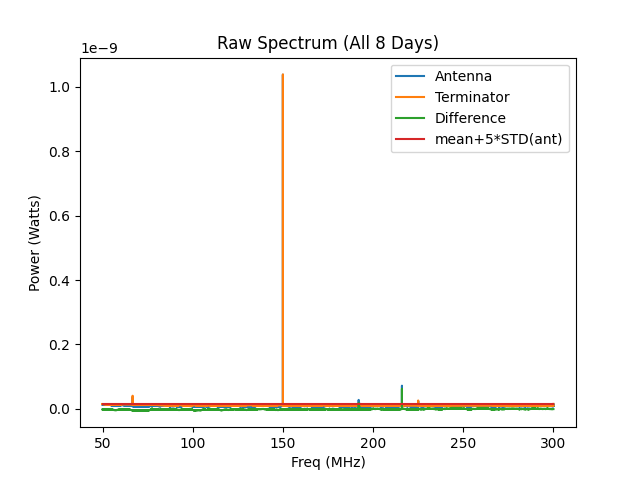

In [10]:
#plot raw averaged spectrum (all data)

dumbLimit = (antSpec.std()*5) + antSpec.mean()
print((antSpec.std()*5))
print((antSpec > dumbLimit).sum(), "candidates (dumb limit)")

plt.close('all')
plt.figure()
plt.title('Raw Spectrum (All 8 Days)')
plt.plot(freqs, antSpec, label = 'Antenna')
plt.plot(freqs, termSpec, label = 'Terminator')
plt.plot(freqs, diffSpec, label = 'Difference')
plt.plot((freqStart, 300),(dumbLimit,dumbLimit), label = 'mean+5*STD(ant)')
plt.xlabel('Freq (MHz)')
plt.ylabel('Power (Watts)')
plt.legend(loc = "upper right")

In [47]:
#filter and plot with 5sigma limit. Note these are not gain corrected!!!

nSigma = 5

antSpecFiltered = dr.filterSpec(antSpec, fc_numBins=30, order=1)
antMad = sp.stats.median_abs_deviation(antSpecFiltered)
antStd = np.std(antSpecFiltered)
antLimitMad = nSigma * antMad * madCor
antLimitStd = nSigma * antStd

termSpecFiltered = dr.filterSpec(termSpec, fc_numBins=30, order = 1)
termMad = sp.stats.median_abs_deviation(termSpecFiltered)
termStd = np.std(termSpecFiltered)
termLimitMad = nSigma * termMad * madCor
termLimitStd = nSigma * termStd

diffSpecFiltered = dr.filterSpec(diffSpec, fc_numBins=30, order = 6)
diffMad = sp.stats.median_abs_deviation(diffSpecFiltered)
diffStd = np.std(diffSpecFiltered)
diffLimitMad = nSigma * diffMad * madCor
diffLimitStd = nSigma * diffStd

nCandidatesAntStd = (antSpecFiltered > antLimitStd).sum()
print('Antenna limit (std) =', antLimitStd, 'Watts')
print('filtered raw antenna data has ', nCandidatesAntStd, 'candidates (std)')
nCandidatesAntMad = (antSpecFiltered > antLimitMad).sum()
print('Antenna limit (mad) =', antLimitMad, 'Watts')
print('filtered raw antenna data has ', nCandidatesAntMad, 'candidates (mad)')
print()
nCandidatesTermStd = (termSpecFiltered > termLimitStd).sum()
print('Terminator limit (std) =', termLimitStd, 'Watts')
print('filtered raw terminator data has ', nCandidatesTermStd, 'candidates (std)')
nCandidatesTermMad = (termSpecFiltered > termLimitMad).sum()
print('Terminator limit (mad) =', termLimitMad, 'Watts')
print('filtered raw terminator data has ', nCandidatesTermMad, 'candidates (mad)')
print()
nCandidatesDiffStd = (diffSpecFiltered > diffLimitStd).sum()
print('diff limit (std) =', diffLimitStd, 'Watts')
print('filtered raw diff data has ', nCandidatesDiffStd, 'candidates (std)')
nCandidatesDiffMad = (diffSpecFiltered > diffLimitMad).sum()
print('diff limit (mad) =', diffLimitMad, 'Watts')
print('filtered raw diff data has ', nCandidatesDiffMad, 'candidates (mad)')

Antenna limit (std) = 1.8074156040450958e-12 Watts
filtered raw antenna data has  14 candidates (std)
Antenna limit (mad) = 1.1896913841791516e-14 Watts
filtered raw antenna data has  1134 candidates (mad)

Terminator limit (std) = 1.802678542587686e-12 Watts
filtered raw terminator data has  8 candidates (std)
Terminator limit (mad) = 1.3744992050293004e-14 Watts
filtered raw terminator data has  191 candidates (mad)

diff limit (std) = 1.2577443686675882e-13 Watts
filtered raw diff data has  125 candidates (std)
diff limit (mad) = 1.893320244086786e-14 Watts
filtered raw diff data has  918 candidates (mad)


mean  =  -0.0001571791599926022
mad * 1.48 =  1.2312453601508986
std =  1.3539161303335183


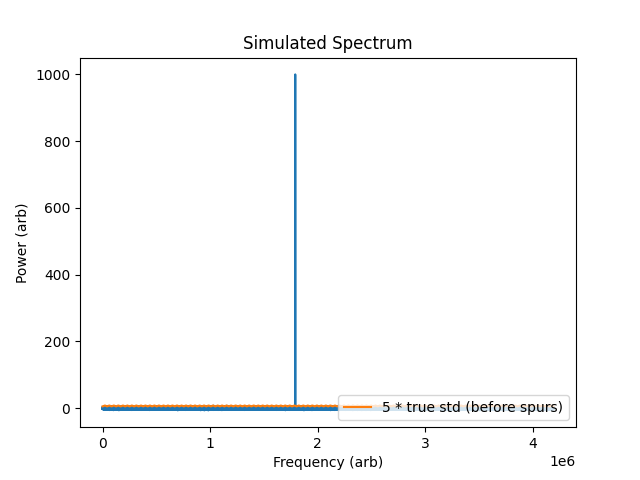

In [2]:
#generate test data (x)

#generate spectrum with known STD (sin^2)
testLength      = 2**22
numStdPoints    = 2**10
stds            = 0.5*np.sin(np.linspace(0, 100*3.14, numStdPoints))**2 + 1
stdsInterp      = 0.5*np.sin(np.linspace(0, 100*3.14, testLength))**2 + 1
x               = np.random.normal(0, stds,  size=(testLength//numStdPoints, numStdPoints)) 
x               = np.reshape(x.T, testLength)

#Inject spurs
x[int(testLength//2.34)] = 1000

plt.figure()
plt.title("Simulated Spectrum")
plt.plot(x)
plt.plot(np.linspace(0, testLength, numStdPoints), stds * 5, label = "5 * true std (before spurs)")
plt.xlabel('Frequency (arb)')
plt.ylabel('Power (arb)')
plt.legend(loc = 'lower right')

print('mean  = ', x.mean())
print('mad * 1.48 = ', 1.4826*sp.stats.median_abs_deviation(x))
print('std = ', np.std(x))


In [4]:
#rolling MAD, mp/shared memmory
#would be nice to wrap this in a function
window = 2000
step = 1
numProc = 46
#spec = diffSpecFiltered
spec = x


def rollingMad(windowIdx):
    existing_shm    = shared_memory.SharedMemory(name=shm.name)
    startBuf        = windowIdx[0] * 8
    windowBufSize   = (windowIdx[1] - windowIdx[0]+1)
    window          = np.frombuffer(shm.buf, offset=startBuf, count=windowBufSize)
    output          = sp.stats.median_abs_deviation(window)
    return output


#Generate array of indicies of windows
#specWindoIdxSpanArr is a 2D array of shape (window,2). 
#Itterating over axis 0 gives len 2 arrays:
#arr[windowStartIdx, windowStopIdx]
specIdxArr              = np.arange(0,len(spec), 1)
specWindowIdxArr        = np.lib.stride_tricks.sliding_window_view(specIdxArr, window)[::step]
specWindowIdxSpanArr    = specWindowIdxArr[:,0::window-1]

#write spec to shared memmory
shm             = shared_memory.SharedMemory(create=True, size=spec.nbytes)
sharedSpec      = np.ndarray(spec.shape, dtype=spec.dtype, buffer=shm.buf) 
sharedSpec[:]   = spec[:] #need colon!

with mp.Pool(numProc) as p:
    rollingList = p.map(rollingMad, specWindowIdxSpanArr)

rollingMadArr = np.asarray(rollingList).reshape(-1)

In [36]:
#rolling MAD, mp/shared memmory
#would be nice to wrap this in a function
window = 1000
step = 1
numProc = 46
#spec = diffSpecFiltered
spec = x

def rollingWorker(windowIdx, args):
    #print('idx =', windowIdx)
    shm             = args[0]
    func            = args[1]
    existing_shm    = shared_memory.SharedMemory(name=shm.name)
    startBuf        = windowIdx[0] * 8
    windowBufSize   = (windowIdx[1] - windowIdx[0]+1)
    window          = np.frombuffer(shm.buf, offset=startBuf, count=windowBufSize)
    #print('window = ', window)
    output          = func(window)
    return output

def rolling(spec, window, step, func, numProc = 48):
    '''
    input:
        spec(array of np.float64):
        Note: MUST be float64 
    ''' 
    #Generate array of indicies of windows
    #specWindoIdxSpanArr is a 2D array of shape (window,2). 
    #Itterating over axis 0 gives len 2 arrays:
    #arr[windowStartIdx, windowStopIdx]
    specIdxArr              = np.arange(0,len(spec), 1)
    specWindowIdxArr        = np.lib.stride_tricks.sliding_window_view(specIdxArr, window)[::step]
    specWindowIdxSpanArr    = specWindowIdxArr[:,0::window-1]

    #write spec to shared memmory
    shm             = shared_memory.SharedMemory(create=True, size=spec.nbytes)
    sharedSpec      = np.ndarray(spec.shape, dtype=spec.dtype, buffer=shm.buf) 
    sharedSpec[:]   = spec[:] #need colon!

    #pack tuple of arguments to pass to worker 
    argsTup = (shm, func)
    workerItter = zip(specWindowIdxSpanArr, itertools.repeat(argsTup))
    with mp.Pool(numProc) as p:
        rollingList = p.starmap(rollingWorker, workerItter)
    print('done mp')
    #print('len rolling list = ', (rollingList))
    rollingMadArr = np.asarray(rollingList).reshape(-1)

    return rollingMadArr

def nanPad(rolledStat, window):
    #pack into array with nan padding
    padStatArr = np.full(len(rolledStat)+window-1, float('nan'))
    padStatArr[window//2:-window//2+1] = rolledStat
    return padStatArr

In [3]:
window = 2000

rollingMadArr = dr.rolling(x, window, 1, sp.stats.median_abs_deviation, numProc=46)

filteredMadArr = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = 20000, type = 'lowpass')
filterMadPadArr = dr.nanPad(filteredMadArr, window)

done mp


done mp


1047577


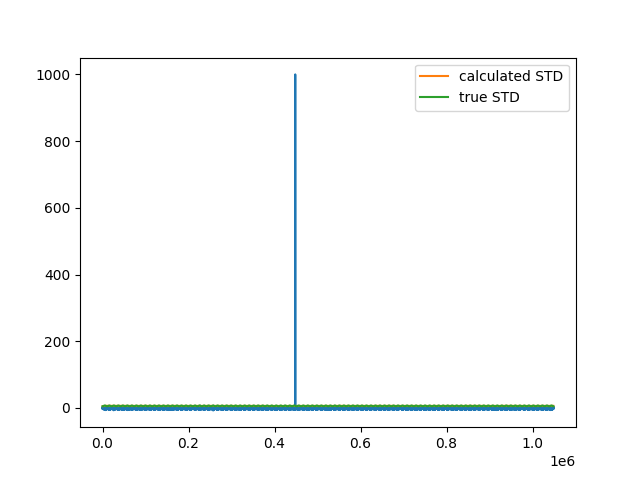

In [18]:
#filter rolling MAD output


#pack into array with nan padding
filteredMadArrPad = np.full(len(spec), float('nan'))
print(len(filteredMadArr))
filteredMadArrPad[window//2:-window//2+1] = filteredMadArr


plt.figure()
plt.plot(x)
plt.plot(filteredMadArrPad * 5 *madCor, label = 'calculated STD')
plt.plot(stdsInterp*5, label = 'true STD')
plt.legend(loc = 'upper right')

In [65]:
#filter rolling MAD output
rollingMadArr = np.asarray(rollingList).reshape(-1)
filteredMadArr = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = 20000, type = 'lowpass')
#pack into array with nan padding
filteredMadArrPad = np.full(len(spec), float('nan'))
filteredMadArrPad[window//2:-window//2+1] = filteredMadArr

filtered raw diff data has  840 candidates (mad)


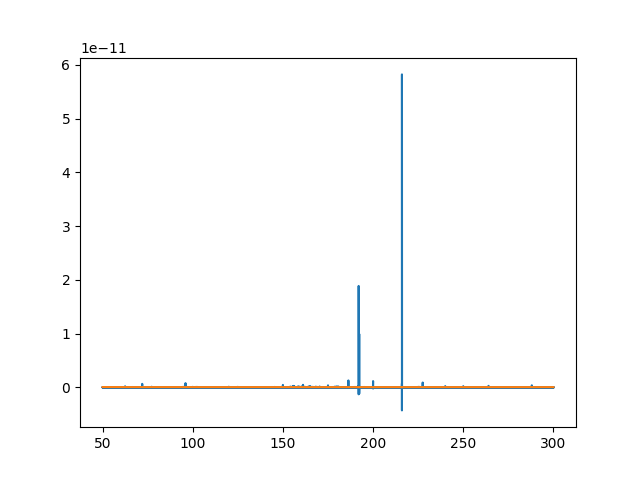

In [66]:
nCandidatesDiffMad = (diffSpecFiltered > filteredMadArrPad*5*madCor).sum()
print('filtered raw diff data has ', nCandidatesDiffMad, 'candidates (mad)')

plt.close('all')
plt.figure()
plt.plot(freqs, diffSpecFiltered)
plt.plot(freqs, filteredMadArrPad*5*madCor)

In [ ]:
#inspect rolling MAD parameters
plt.close('all')
plt.figure()
plt.plot(freqs, antSpecFiltered)
#plt.plot(rollingMadArr*5*madCor)
plt.plot(freqs, filteredMadArrPad*5*madCor)
#plt.plot(np.linspace(0, testLength, numStdPoints), stds * 5, label = "5 * true std (before spurs)")
#plt.plot(dr.filterSpec(rollingMadArr*5*madCor, order = 2, fc_numBins = 1000, type = 'lowpass'), label = 'filtered rolling mad')
plt.legend(loc = 'upper right')

plt.figure()
plt.plot(filteredMadArrPad*madCor)
plt.plot(stdsInterp , label = "5 * true std (before spurs)")
plt.legend(loc = 'upper right')

plt.figure()
plt.plot((stdsInterp - madCor*filteredMadArrPad))

#plt.plot(rollingMadArr*5*madCor)
#plt.plot(dr.filterSpec(rollingMadArr*5*madCor, order = 2, fc_numBins = 500, type = 'lowpass'))

#plt.plot(((rollingMadMp*madCor)[1:] - stdsInterp)/stdsInterp)

stdErr = ((stdsInterp - madCor*filteredMadArrPad)/stdsInterp)
stdErrStd = stdErr[np.logical_not(np.isnan(stdErr))].std()
print(stdErrStd)

In [ ]:
#filter, remove center spur. 
# plot with 5sigma limit. Note these are not gain corrected!!!

#set center interleaving spur to it's negbor. See spur hunting sheet for these indicies
antSpecClean = (antSpec)

idxInterleaving = range(4194301-idxStart,4194306-idxStart)
for i in idxInterleaving:
    antSpecClean[i] =  antSpecClean[i+5]

antSpecCleanFilter = dr.filterSpec(antSpecClean)

antMAD = (sp.stats.median_abs_deviation(antSpecCleanFilter))
antLimit = 5 * antMAD
print('limit = ', antLimit, 'Watts')

nCandidates = (antSpecCleanFilter > antLimit).sum()
print('filtered raw data has ', nCandidates, 'candidates')




plt.figure()
plt.plot(freqs, dr.filterSpec(antSpecClean))
plt.plot((freqStart, 300),(antLimit, antLimit))


'''
antLimit = dr.fft2Watts(5 * sp.stats.median_abs_deviation(dr.filterSpec(antDataAll[idxStart:idxStart + 1000])))

nCandidates = (filteredAntSpecWatts > antLimit).sum()
print('filtered raw data has ', nCandidates, 'candidates')

%matplotlib widget
plt.close('all')

plt.figure()
plt.title('Filtered Spectrum (All 8 Days)')
plt.plot(freqs[idxStart:], filteredAntSpecWatts)
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')


plt.figure()
plt.title('Zoom Filtered Spectrum (All 8 Days)')
plt.plot(freqs[idxStart:], filteredAntSpecWatts)
plt.plot((freqStart, 300),(antLimit, antLimit))
plt.xlabel('Freq (MHz)')
plt.ylabel('Filtered Power (Watts)')
plt.ylim(-2e-13, 2e-13)
'''

In [ ]:
#mp spcipy based homebrew 
#print(x)
window = 5000
step = 1
spec = x

strideSpec = np.lib.stride_tricks.sliding_window_view(spec,window)

#multiprocess rolling MAD on strided array
def MAD(spec):
    #print(spec)
    #return np.full(step, sp.stats.median_abs_deviation(spec))
    return sp.stats.median_abs_deviation(spec)
with mp.Pool(40) as p:
    rollingMadMp = p.map(MAD, strideSpec[::step])

rollingMadMp = np.asarray(rollingMadMp).reshape(-1)

'''
infArr = np.full(window//2, float('nan'))
rollingMadMp = np.append(infArr, rollingMadMp)
rollingMadMp = np.append(rollingMadMp, infArr)
'''


In [ ]:
window = 3
step = 2
spec = x
strideSpec = np.lib.stride_tricks.sliding_window_view(spec,window)
rollingMadMp = np.zeros(len(spec - window))

for i, spec in enumerate(strideSpec[::step]):
    rollingMadMp[i] = sp.stats.median_abs_deviation(spec)


In [ ]:
#rolling std using pd rolling
antSpecFiltered = dr.filterSpec(antSpec)
termSpecFiltered = dr.filterSpec(termSpec)



antFilter_Df = pd.DataFrame(antSpecFiltered)
antRollingStd = antFilter_Df.rolling(10000).std()
termFilter_Df = pd.DataFrame(termSpecFiltered)
termRollingStd = termFilter_Df.rolling(10000).std()
termRollingMad = rollingMadMp

numTermCandidates = (termSpecFiltered > (6*termRollingStd).to_numpy().T[0]).sum()
numAntCandidates = (antSpecFiltered > (6*antRollingStd).to_numpy().T[0]).sum()
print(numTermCandidates, 'candidates on terminator')
print(numAntCandidates, 'candidates on antenna')

plt.figure()
plt.title('antenna')
plt.plot(antSpecFiltered)
plt.plot(antRollingStd*5)

plt.figure()
plt.title('terminator')
plt.plot(termSpecFiltered)
plt.plot(termRollingStd*5)
plt.plot(termRollingMad*5)

plt.figure()
plt.plot(antSpec)
plt.plot(termSpec)



In [ ]:
plt.figure()
plt.plot(rollingMad)
plt.plot(rollingStd * .67)

NameError: name 'freqs' is not defined

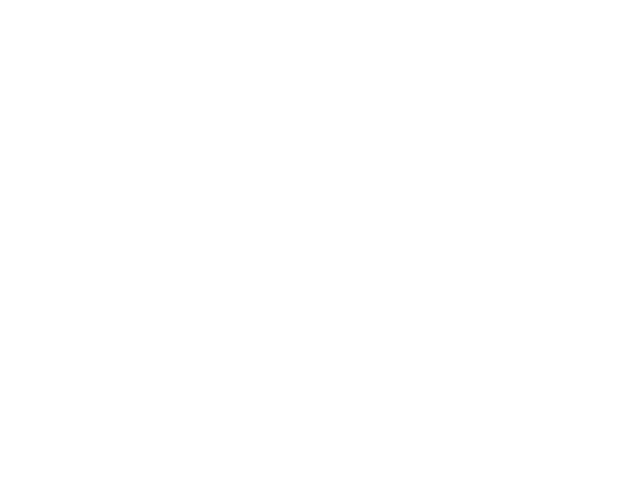

In [44]:
#pandas rolling std

df = pd.DataFrame(antSpecCleanFilter)
arr = np.asarray(df.rolling(10000).std())
limit = 6 * arr

plt.figure()
plt.plot(freqs, antSpecCleanFilter)
plt.plot(freqs, limit, label = '5sigma thresh')

'''
count = 0
for i in range(len(antSpecCleanFilter)):
    if antSpecCleanFilter[i]>limit[i]:
        count += 1
print(count)
'''

In [ ]:
df = pd.DataFrame(antSpec)
arr = (df.rolling(100).median())
diff = (df - arr)
std = 5 * diff.rolling(10000).std()

plt.figure()
plt.plot(freqs, antSpec)
plt.plot(freqs,arr)

plt.figure()
plt.plot(freqs, diff)
plt.plot(freqs, std)



In [ ]:
plt.close('all')
plt.figure()
plt.plot(a)

In [ ]:
#show interleaving spur is single bin wide

plt.close('all')
plt.figure()
plt.scatter(freqs*1e6, dr.fft2dBm(antDataAll))
plt.xlabel('Freq (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(1.499990e8, 1.500010e8)
plt.ylim(-82,-58)

In [ ]:
parsedList, configDic = getParsedList('ConfigDR.ini', 'TEST');

avgSpec = dr.avgSpec(parsedList, '../../../../drBiggerBoy/drData/Data/', verbose=True)